# Imports

In [ ]:
import pandas as pd
import numpy as np
import random as rd
from random import sample as sp
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import lightgbm as lgb

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score


from google.colab import drive
drive.mount('/content/gdrive')

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# altere aqui
worksheet = gc.open('Respostas_Formulario').sheet1
# worksheet = gc.open('Respostas Formulario Projeto 6').sheet1

# get_all_values gives a list of rows.
respostas_form = worksheet.get_all_values()

# Convert to a DataFrame and render.
import pandas as pd
df_responses = pd.DataFrame.from_records(respostas_form)

# Spotify Multi-Genre Playlists
rock_music = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Projeto_6/Spotify_Multi-Genre_Playlists_Data/rock_music_data.csv')
pop_music = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Projeto_6/Spotify_Multi-Genre_Playlists_Data/pop_music_data.csv')
metal_music = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Projeto_6/Spotify_Multi-Genre_Playlists_Data/metal_music_data.csv')
indie_alt_music = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Projeto_6/Spotify_Multi-Genre_Playlists_Data/indie_alt_music_data.csv')
hiphop_music = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Projeto_6/Spotify_Multi-Genre_Playlists_Data/hiphop_music_data.csv')
blues_music = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Projeto_6/Spotify_Multi-Genre_Playlists_Data/blues_music_data.csv')
alternative_music = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Projeto_6/Spotify_Multi-Genre_Playlists_Data/alternative_music_data.csv')

Mounted at /content/gdrive


# Dicionarios dos dados


**- Matrix_[Alegria]:** Resposta do usuario da pergunta de relacao entre a emocao de Alegria e genero musical.

**- Matrix_[Tristeza]:** Resposta do usuario da pergunta de relacao entre a emocao de Tristeza e genero musical.

**- Matrix_[Cansaco]:** Resposta do usuario da pergunta de relacao entre a emocao de Cansaco e genero musical.

**- Matrix_[Calma]:** Resposta do usuario da pergunta de relacao entre a emocao de Calma e genero musical.

**- Matrix_[Raiva]:** Resposta do usuario da pergunta de relacao entre a emocao de Raiva e genero musical.

**- Alegre["caracteristica"], Triste["caracteristica"], ..., Raiva["caracteristica"]:** Caracterizacao das musicas que o usuario escuta para cada emocao, utilizando uma escala de 1-5. Por exemplo: Alegre[Feliz] = 5, significando que aquele usuario, quando esta alegre, escuta musicas com um nivel de felicidade mais alto. Ou Alegre[BPM] = 5, significando que este usuario, quando alegre, escuta musicas com um BPM mais alto.

**- Caracteristicas:**

 - **BPM(Beats per Minute / Batidas por Minuto):** Nivel que vai medir a Velocidade do ritmo, das batidas, da musica. Se tem mais batidas por minuto, ou menos.

 - **Energia/Energetica:** Nivel que mede se a musica eh mais alta, mais barulhenta, ou menos.

 - **Feliz:** Nivel que vai medir a felicidade/positividade da musica. Podendo ser menos ou mais positiva.

**- Periodo:** Qual periodo da faculdade de graduacao que o usuario estuda no momento do envio da resposta.

**- Genero:** Genero de cada usuario Feminino, Masculino, Nao binario, Prefiro nao dizer

**- Idade:** Idade de cada usuario

In [ ]:
df_responses.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,Timestamp,"Quando voce sente as emoções listadas abaixo, ...","Quando voce sente as emoções listadas abaixo, ...","Quando voce sente as emoções listadas abaixo, ...","Quando voce sente as emoções listadas abaixo, ...","Quando voce sente as emoções listadas abaixo, ...","De 1-5, como você caracteriza as músicas que v...","De 1-5, como você caracteriza as músicas que v...","De 1-5, como você caracteriza as músicas que v...","De acordo com cada emoção, caracterize o nível...",...,Caso tenha selecionado a opção de Outra emoção...,"De 1-5, como você caracteriza as músicas que v...","De 1-5, como você caracteriza as músicas que v...","De 1-5, como você caracteriza as músicas que v...","De 1-5, como você caracteriza as músicas que v...","De 1-5, como você caracteriza as músicas que v...","De acordo com cada emoção, caracterize o nível...","De acordo com cada emoção, caracterize o nível...","De acordo com cada emoção, caracterize o nível...","De acordo com cada emoção, caracterize o nível..."
1,4/26/2023 14:07:45,Outra,Pop,Pop,Outra,Outra,2,2,2,,...,,,,,,,,,,
2,4/26/2023 14:08:23,"Hip-Hop, Pop",Rock,Pop,Hip-Hop,Outra,1,4,5,,...,,,,,,,,,,
3,4/26/2023 14:10:26,"Hip-Hop, Indie, Rock","Blues, Hip-Hop, Outra","Hip-Hop, Outra","Blues, Hip-Hop, Outra","Hip-Hop, Rock",2,5,3,,...,,,,,,,,,,
4,4/26/2023 15:50:20,"Alternativa, Blues, Hip-Hop, Indie","Alternativa, Blues, Hip-Hop, Indie","Alternativa, Blues, Hip-Hop, Indie","Alternativa, Blues, Hip-Hop, Indie","Alternativa, Blues, Hip-Hop, Indie",2,1,3,,...,,,,,,,,,,


# Tratamento forms

### Dropando colunas para melhor vizualizacao

In [ ]:
# Dropando linhas e colunas que contem valores nulos
df_responses = df_responses[df_responses.columns[:25]]
df_responses = df_responses.drop(columns=[9], axis=1)

# Drpando timestamp
df_responses = df_responses.drop(columns=[0], axis=1)
df_responses = df_responses.drop(0, axis=0)

# Renomeando as colunas para melhorar entendimento
newColumnsName = ["Matrix_[Alegria]","Matrix_[Tristeza]","Matrix_[Cansaco]","Matrix_[Calma]",
                  "Matrix_[Raiva]",  "Alegre[Feliz]",   "Alegre[Energética]","Alegre[BPM]",
                  "Triste[Feliz]",   "Triste[Energética]","Triste[BPM]","Cansado[Feliz]",
                  "Cansado[Energétia]","Cansado[BPM]","Calmo[Feliz]","Calmo[Energética]",
                  "Calmo[BPM]", "Raiva[Feliz]","Raiva[Energética]","Raiva[BPM]","Idade","Genero","Periodo"]

df_responses = df_responses.set_axis(newColumnsName, axis="columns")

# Convertendo o tipo para string
columnsName = ['Matrix_[Alegria]', 'Matrix_[Tristeza]', 'Matrix_[Cansaco]', 'Matrix_[Calma]', 'Matrix_[Raiva]']

for column in columnsName:
    df_responses[column] = df_responses[column].astype("string")

Algumas colunas com valores nulos estao sendo dropadas para melhorar aprendizado do nosso modelo e eliminar qualquer vies. Dado que os dados se originam de um formulario do Google, foi preciso renomear algumas colunas para melhor entendimento da equipe de ML

### Tratamento das colunas idades, periodo e genero

Usando LabelEncoder para tratar as idades, vamos representar da seguinte forma:

0 - para idades menor que 18

1 - para idades entre  18 &  21

2 - para idades entre 22 & 28

3 - para idades entre 29 & 35

4 - para idades maior que 35

In [ ]:
#OneHotEncoder para a coluna Genero

ohe_g = OneHotEncoder(handle_unknown='ignore')

ohe_g.fit(df_responses[['Genero']])

cols = ohe_g.categories_

ohe_g_trans = ohe_g.transform(df_responses[['Genero']]).toarray()

ohe_g_trans_db = pd.DataFrame(ohe_g_trans, columns=cols)

ohe_g_trans_db['Feminino'] = ohe_g_trans_db['Feminino'].astype(int)

ohe_g_trans_db['Masculino'] = ohe_g_trans_db['Masculino'].astype(int)

In [ ]:
ohe_g_trans_db.head()

,Feminino,Masculino
0,1,0
1,0,1
2,0,1
3,0,1
4,1,0


In [ ]:
#Transformando Idades e Periodo com LabelEncoder
lbe_i = LabelEncoder()
lbe_i.fit(df_responses['Idade'])
lbe_i_trans = lbe_i.transform(df_responses['Idade'])

lbe_p = LabelEncoder()
lbe_p.fit(df_responses['Periodo'])
lbe_p_trans = lbe_p.transform(df_responses['Periodo'])

In [ ]:
#Fazendo as substituicoes no Dataset

#Dropando as colunas originais
df_responses = df_responses.drop(columns=['Idade','Genero','Periodo'])

#Dropando coluna Index criada automaticamente
df_responses = df_responses.reset_index()
df_responses = df_responses.drop(columns=['index'])

# Adicionando valores transformados
df_responses['Idade'] = lbe_i_trans
df_responses['G_Feminino'] = ohe_g_trans_db['Feminino']
df_responses['G_Masculino'] = ohe_g_trans_db['Masculino']
df_responses['Periodo'] = lbe_p_trans

### Dividindo o dataset em subdatasets, para cada emocao, incluindo as colunas de cada emocao.

In [ ]:
columns = {
    "Alegria": ["Matrix_[Alegria]", "Alegre[Feliz]", "Alegre[Energética]", "Alegre[BPM]"],
    "Tristeza": ["Matrix_[Tristeza]", "Triste[Feliz]", "Triste[Energética]", "Triste[BPM]"],
    "Cansado": ["Matrix_[Cansaco]", "Cansado[Feliz]", "Cansado[Energétia]", "Cansado[BPM]"],
    "Calma": ["Matrix_[Calma]", "Calmo[Feliz]", "Calmo[Energética]", "Calmo[BPM]"],
    "Raiva": ["Matrix_[Raiva]", "Raiva[Feliz]", "Raiva[Energética]", "Raiva[BPM]"]
}

dfs = {}

for key, value in columns.items():
    dfs[key] = df_responses[value]

# Exemplo de acesso aos dataframes:
df_alegre = dfs["Alegria"]
df_tristeza = dfs["Tristeza"]
df_cansado = dfs["Cansado"]
df_calma = dfs["Calma"]
df_raiva = dfs["Raiva"]

### Incluir as colunas Periodo, Genero e Idade em todos subdatasets.

In [ ]:
datasets = [df_alegre, df_tristeza, df_cansado, df_calma, df_raiva]

columns = ['Idade', 'G_Feminino', 'G_Masculino', 'Periodo']

for dataset in datasets:
    for column in columns:
         dataset.loc[:, column] = df_responses[column].copy()


<ipython-input-9-cb5e70dd2477>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, column] = df_responses[column].copy()
<ipython-input-9-cb5e70dd2477>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, column] = df_responses[column].copy()
<ipython-input-9-cb5e70dd2477>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

### Criar coluna de identificação do usuario para cada subdataset.


In [ ]:
array = []

for i in range(1, len(df_responses) + 1):
 array.append(i)

df_alegre['ID'] = array
df_tristeza['ID'] = array
df_cansado['ID'] = array
df_calma['ID'] = array
df_raiva['ID'] = array

<ipython-input-10-f6f6a82b50ff>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alegre['ID'] = array
<ipython-input-10-f6f6a82b50ff>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tristeza['ID'] = array
<ipython-input-10-f6f6a82b50ff>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

### Criar N novas linhas para cada valor de genero que o usuario respondeu.


In [ ]:
# Funcao para pegar todas as colunas de um dataset.
def get_all_columns(df):
    columns = list(df.columns)
    return columns

# Funcao para criar N novas linhas para cada valor de genero que o usuario respondeu.
def process_dataset(df, column):
    df_copy = df.drop(column, axis=1)
    # Copiando todo o dataset que sera passado como parametro, menos a coluna do parametro, que eh justamente o valor que vai ser substituido.

    column_names = get_all_columns(df)

    df_final = pd.DataFrame(columns=column_names)
    # df_final eh o dataset resultado, eh onde vai estar sendo inserida as linhas. Comeca como um dataset vazio, e vou adicionando linha por linha.

    array = []
    iterate = 0
    num_rows = 0
    row = []
    # Variaveis auxiliares:

    # array -> armazenar os generos depois do split(',') e utilizar para colocar os generos nas linhas que vao ser criadas.

    # iterate -> contador que vai incrementar a cada iteracao do loop for.

    # num_rows -> contador para o numero de linhas, para quando for adicionar no dataset df_final_alegria, a linha ser adicionada no local certo.

    # row -> vai armazenar a linha para depois ser inserida no dataset df_final_alegria.

    for linha in df[column]:
        index = linha.find(',')
        if index != -1:
            array = linha.split(',')
            for i in range(len(array)):

                row = df_copy.loc[[iterate]].to_numpy() # Salva na variavel temporaria 'row' o valor presente na linha 'iterate'.
                row = np.squeeze(row).tolist() # Transforma o row, que vem como uma matriz, em uma lista, e transforma o array numpy em array normal.
                row.insert(0, array[i]) # Coloca no indice 0 do row, o genero musical presente no indice 'i' da lista de generos 'array'.
                df_final.loc[num_rows] = row # Adiciona no dataset df_final a linha criada, no indice 'num_rows'.
                num_rows += 1 # Adiciona mais uma linha no contador de linhas
        else:
            row = df_copy.loc[[iterate]].to_numpy()
            row = np.squeeze(row).tolist()
            row.insert(0, linha)
            df_final.loc[num_rows] = row
            num_rows += 1
        iterate += 1

    return df_final


df_final_alegria = process_dataset(df_alegre, 'Matrix_[Alegria]')
df_final_tristeza = process_dataset(df_tristeza, 'Matrix_[Tristeza]')
df_final_cansado = process_dataset(df_cansado, 'Matrix_[Cansaco]')
df_final_calma = process_dataset(df_calma, 'Matrix_[Calma]')
df_final_raiva = process_dataset(df_raiva, 'Matrix_[Raiva]')

### Unificar os subdatasets em um unico dataset.

In [ ]:
#renomeando as colunas de cada subdataset para um padrao de nome
new_columnsName = ['Genero', 'Nivel_Feliz', 'Nivel_Energetica', 'Nivel_BPM', 'Idade', 'G_Feminino', 'G_Masculino', 'Periodo', 'ID']

datasets_emocoes = [df_final_alegria, df_final_tristeza, df_final_cansado, df_final_calma, df_final_raiva]
emocoes = ['Alegria', 'Tristeza', 'Cansaço', 'Calma', 'Raiva']
def rename_columns(datasets, new_column_names):
    for dataset in datasets:
        dataset.columns = new_column_names

rename_columns(datasets_emocoes,new_columnsName)

In [ ]:
#Adicionando a coluna emocoes para cada subdataset


def add_emotion_column(datasets, emocoes):
  for dataset, emocao in zip(datasets, emocoes):
    for i in range(len(dataset)):
          dataset.loc[i, 'Emocoes'] = emocao

add_emotion_column(datasets_emocoes, emocoes)

In [ ]:
df_final = pd.concat(datasets_emocoes, ignore_index=True)

### Fazer OneHotEncoder para os generos no dataset final


In [ ]:
#Removendo espacos em branco
df_final['Genero'] = df_final['Genero'].str.strip()

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', categories='auto')

encoder.fit(df_final[['Genero']])

categories = encoder.categories_

encoded_data = encoder.transform(df_final[['Genero']])

df_final_ohe = pd.DataFrame(encoded_data, columns=categories)


#Dropando a coluna genero derivada do OneHotEncoder
df_final = df_final.drop(columns=['Genero'])

#Tirando parenteses e virgulas das novas colunas apos o one hot encoder
new_columns = df_final_ohe.columns.get_level_values(0).str.strip("(),")

df_final_ohe.columns = new_columns

df_final = pd.concat([df_final, df_final_ohe], axis=1)

df_final = df_final.drop(['Outro', 'Outra'], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### One Hot Encoder encoder para coluna Emocoes


In [ ]:
encoder_emo = OneHotEncoder(sparse=False, handle_unknown='ignore', categories='auto')

encoder_emo.fit(df_final[['Emocoes']])

categories_emo = encoder_emo.categories_

encoded_data_emo = encoder_emo.transform(df_final[['Emocoes']])

df_final_ohe_emo = pd.DataFrame(encoded_data_emo, columns=categories_emo)


# Dropando a coluna genero derivada do OneHotEncoder
df_final = df_final.drop(columns=['Emocoes'])

# Tirando parenteses e virgulas das novas colunas apos o one hot encoder

new_columns_emo = df_final_ohe_emo.columns.get_level_values(0).str.strip("(),")

df_final_ohe_emo.columns = new_columns_emo

df_final = pd.concat([df_final, df_final_ohe_emo], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
df_final = df_final.astype("int64")

#EDA

In [ ]:
df_final.head(5)

,Nivel_Feliz,Nivel_Energetica,Nivel_BPM,Idade,G_Feminino,G_Masculino,Periodo,ID,Alternativa,Blues,Hip-Hop,Indie,Metal,Pop,Rock,Alegria,Calma,Cansaço,Raiva,Tristeza
0,2,2,2,1,1,0,7,1,0,0,0,0,0,0,0,1,0,0,0,0
1,1,4,5,0,0,1,3,2,0,0,1,0,0,0,0,1,0,0,0,0
2,1,4,5,0,0,1,3,2,0,0,0,0,0,1,0,1,0,0,0,0
3,2,5,3,1,0,1,5,3,0,0,1,0,0,0,0,1,0,0,0,0
4,2,5,3,1,0,1,5,3,0,0,0,1,0,0,0,1,0,0,0,0


<Axes: >

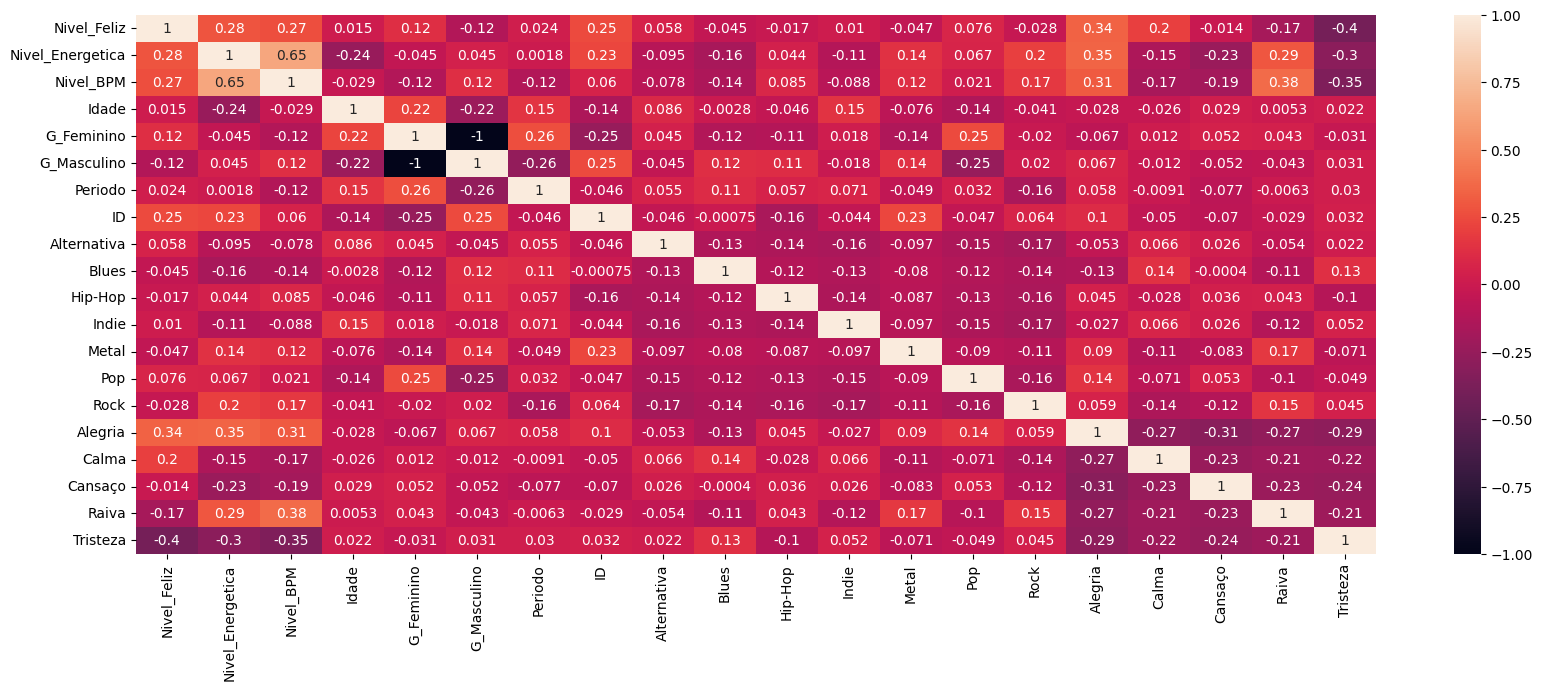

In [ ]:
plt.figure(figsize=(20,7))
df_final_corr = df_final.corr()
sns.heatmap(df_final_corr, annot=True)

Analisando o Heatmap acima, nos identificamos algumas colunas interessantes para analisarmos. Primeiramente, olhamos para as colunas "Nivel_BPM" e "Nivel_Energetica" e vimos uma correlacao relativamente alta, com um valor de 0.65. Sabendo o significado de cada coluna, que Nivel_BPM representa o as batidas por minuto (BPM) de uma musica, e que Nivel_Energetica indica se uma musica eh mais ou menos energetica, identificamos que essa alta correlacao faz sentido, uma vez que musicas com mais batidas por minuto geralmente sao mais rapidas, mais energeticas, mais agitadas.

Ainda com a coluna "Nivel_BPM", tambem observamos uma correlacao interessante com a coluna "Raiva". Eh possivel observar uma correlacao de 0.38, que nao eh muito alta, porem chama a atencao. Essa correlacao pode indicar que algumas pessoas que estao sentindo raiva podem tender a escutar musicas com um nivel de batidas por minuto mais alto. E pesquisando sobre a relacao de musica com a emocao de pessoas, encontramos uma pesquisa feita por pesquisadores de diferentes universidades, que indicava que musicas mais intensas, como o rock, podem aumentar afetos negativos, como a raiva. Sabendo disso, foi possivel compreender melhor a correlacao identificada, ja que tem pessoas que quando sentem uma emocao, buscam musicas para intensificar essa tal emocao. No nosso caso, essa emocao eh a raiva e as musicas do estilo rock.
Isso ainda se confirma, quando visto as correlacoes entre os generos musicais e a emocao Raiva, pois os generos Rock e Metal sao os que tem as maiores correlacoes, dentro desse conjunto.

Alem dessas observacoes, tambem identificamos uma correlacao um pouco elevada entre as colunas "Tristeza" e "Nivel_Feliz", tendo um valor de -0.4. Essa correlacao mostra que algumas pessoas tendem a escutar musicas com um nivel menor de felicidade quando estao tristes, possivelmente como uma forma de lidar com a emocao. Isso corrobora com o que foi dito e observado anteriormente, sobre as colunas "Raiva" e "Nivel_BPM", que algumas pessoas buscam musicas que intensifiquem a emocao que esta sentindo. Porem, assim como tambem eh mostrado pela correlacao, que nao eh tao alta, algumas pessoas decidem pelo contrario, escutar musicas mais felizes quando estao tristes, provavelmente na tentativa de combater a emocao negativa. O que pode ser uma alternativa mais saudavel, de acordo com a pesquisa citada anteriormente.

*Pesquisa feita com diferentes instituicoes:* http://www.redemacuco.com.br/2020/11/17/preferencia-por-ritmos-intensos-de-musica-tem-efeitos-no-nivel-de-bem-estar/

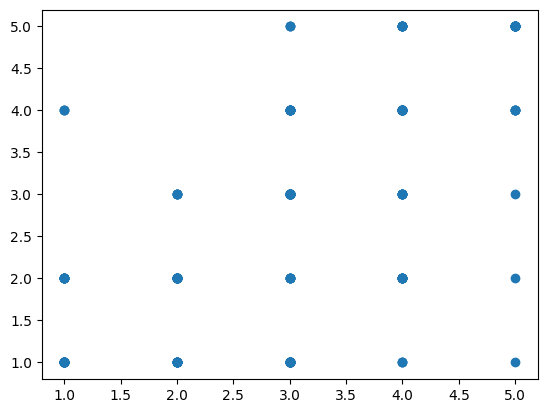

In [ ]:
plt.scatter(data=df_final, x='Nivel_BPM', y='Nivel_Energetica')
plt.show()

Observando o ScatterPlot acima, eh possivel observar melhor o porque dessa maior correlacao entre as colunas "Nivel_BPM" e "Nivel_Energetica", ja que a maior parte dos valores com Nivel_BPM maior ou igual a 3 (considerado um valor de BPM mediano para alto) tambem possuem um Nivel_Energetica maior ou igual a 3.

# Divisão da base de treino e teste

In [ ]:
#Vizualizacao do dataframe final para ser aplicado no KNN
df_final

,Nivel_Feliz,Nivel_Energetica,Nivel_BPM,Idade,G_Feminino,G_Masculino,Periodo,ID,Alternativa,Blues,Hip-Hop,Indie,Metal,Pop,Rock,Alegria,Calma,Cansaço,Raiva,Tristeza
0,2,2,2,1,1,0,7,1,0,0,0,0,0,0,0,1,0,0,0,0
1,1,4,5,0,0,1,3,2,0,0,1,0,0,0,0,1,0,0,0,0
2,1,4,5,0,0,1,3,2,0,0,0,0,0,1,0,1,0,0,0,0
3,2,5,3,1,0,1,5,3,0,0,1,0,0,0,0,1,0,0,0,0
4,2,5,3,1,0,1,5,3,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,1,1,1,1,0,1,4,19,0,0,0,0,0,0,0,0,0,0,1,0
245,1,5,4,1,0,1,5,20,0,0,0,0,0,0,1,0,0,0,1,0
246,1,5,4,1,0,1,5,20,0,0,0,0,1,0,0,0,0,0,1,0
247,4,4,4,1,0,1,0,21,0,0,0,0,1,0,0,0,0,0,1,0


In [ ]:
# Separar os dados de entrada e saída

X = df_final[['Alegria','Calma','Cansaço','Raiva','Tristeza']] # Atributos de entrada
Y = df_final[['Alegria','Calma','Cansaço','Raiva','Tristeza','Nivel_Feliz', 'Nivel_Energetica', 'Nivel_BPM', 'Alternativa', 'Blues', 'Hip-Hop', 'Indie', 'Metal', 'Pop', 'Rock']] # Atributos de saida

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


# Normaliza os dados
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# KNN

### Implementação e execução do KNN

In [ ]:
# Criar uma instância do KNeighborsClassifier para o MultiOutputClassifier, inserindo na Pipeline

pipe = Pipeline(steps=[('KNN',MultiOutputClassifier(KNeighborsClassifier(n_neighbors=13, weights='distance', algorithm='auto')))])
pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)
print('\nScore:', round(pipe.score(X_test, y_test),3))


Score: 0.013


Como o primeiro metodo de classificacao, escolhemos o KNN por termos mais familiariedade, e por se encaixar bem com o nosso problema. Alem disso, tambem escolhemos um numero de vizinhos igual a 13, pois observamos que assim obtinhamos o melhor Score.

Notamos que, mesmo mexendo nos parametros, obtivemos um Score muito baixo, porem imaginamos que seja causado pela quantidade de dados, ou pelo formato de saida do nosso modelo, que tem que conter varios outputs.

In [ ]:
df_y_pred = pd.DataFrame(y_pred, columns=[['Alegria','Calma','Cansaço','Raiva','Tristeza','Nivel_Feliz', 'Nivel_Energetica', 'Nivel_BPM', 'Alternativa', 'Blues', 'Hip-Hop', 'Indie', 'Metal', 'Pop', 'Rock']])

df_y_pred

,Alegria,Calma,Cansaço,Raiva,Tristeza,Nivel_Feliz,Nivel_Energetica,Nivel_BPM,Alternativa,Blues,Hip-Hop,Indie,Metal,Pop,Rock
0,0,0,1,0,0,2,1,3,0,0,0,0,0,0,0
1,1,0,0,0,0,5,4,4,0,0,0,0,0,0,0
2,0,0,0,0,1,2,1,2,0,0,0,0,0,0,0
3,1,0,0,0,0,5,4,4,0,0,0,0,0,0,0
4,0,0,1,0,0,2,1,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0,0,0,0,1,2,1,2,0,0,0,0,0,0,0
71,0,0,0,1,0,3,4,4,0,0,0,0,0,0,0
72,0,0,1,0,0,2,1,3,0,0,0,0,0,0,0
73,0,0,0,0,1,2,1,2,0,0,0,0,0,0,0


# MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

# classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), random_state=1, max_iter=300)
pipe_mlp = Pipeline(steps=[('MLP',MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(150,100,50), random_state=1, max_iter=300)))])

pipe_mlp.fit(X_train,y_train)

preditions = pipe_mlp.predict(X_test)

In [ ]:
df_preditions = pd.DataFrame(preditions)

df_preditions = df_preditions.values.tolist()

df_y_predMLP = pd.DataFrame(df_preditions, columns=[['Alegria','Calma','Cansaço','Raiva','Tristeza','Nivel_Feliz', 'Nivel_Energetica', 'Nivel_BPM', 'Alternativa', 'Blues', 'Hip-Hop', 'Indie', 'Metal', 'Pop', 'Rock']])

df_y_predMLP

,Alegria,Calma,Cansaço,Raiva,Tristeza,Nivel_Feliz,Nivel_Energetica,Nivel_BPM,Alternativa,Blues,Hip-Hop,Indie,Metal,Pop,Rock
0,0,0,1,0,0,3,3,3,0,0,0,0,0,0,0
1,1,0,0,0,0,5,4,4,0,0,0,0,0,0,0
2,0,0,0,0,1,2,1,2,0,0,0,0,0,0,0
3,1,0,0,0,0,5,4,4,0,0,0,0,0,0,0
4,0,0,1,0,0,3,3,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0,0,0,0,1,2,1,2,0,0,0,0,0,0,0
71,0,0,0,1,0,3,4,4,0,0,0,0,0,0,0
72,0,0,1,0,0,3,3,3,0,0,0,0,0,0,0
73,0,0,0,0,1,2,1,2,0,0,0,0,0,0,0


In [ ]:
print(round(pipe_mlp.score(X_test,y_test), 3))

0.027


Para o modelo mais complexo, primeiro pensamos no LightGBM, porem tivemos varios erros, e pelo curto tempo, optamos pelo MLP Classifier. Para implementar esse modelo no nosso problema, que exige uma saida com varios valores (varios outputs), escolhemos realizar um predict para cada coluna, e ir juntando esses resultados em um novo dataframe.

# Tratamento dataset Spotify

### Modificar a coluna Genero para valores especificos


In [ ]:
# Modificar a coluna Genero para valores especificos
datasets_spotify = [rock_music, pop_music, metal_music, indie_alt_music, hiphop_music, blues_music, alternative_music]
genres = ["Rock", "Pop", "Metal", "Indie", "Hip-Hop", "Blues", "Alternativa"]
iterate = 0

for dataset in datasets_spotify:
  dataset = dataset.drop(columns='Genres')
  for row in range(len(dataset)):
    dataset.loc[row, 'Genre'] = genres[iterate]
  datasets_spotify[iterate] = dataset
  iterate += 1

### Unificar os datasets do spotify, dos generos musicais em um unico dataset.
### Remocao de algumas colunas que nao serusadaa  por enquanto em nosso projeto


In [ ]:
# Unificar os datasets do spotify, dos generos musicais em um unico dataset.

df_spotify_final = pd.concat(datasets_spotify, ignore_index=True)

In [ ]:
# remocao de algumas colunas que nao serusadaa  por enquanto em nosso projeto
df_spotify_final = df_spotify_final.drop(['time_signature', 'duration_ms', 'analysis_url', 'track_href', 'id', 'danceability',
                                          'liveness', 'instrumentalness', 'acousticness', 'speechiness', 'mode', 'loudness', 'key'], axis=1)

### Normalizacao das colunas referente a caracteristicas das musicas

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df_spotify_final[['energy','valence','tempo']])
df_spotify_final[['energy','valence','tempo']] = scaler.transform(df_spotify_final[['energy','valence','tempo']])
df_spotify_final.head()

,Artist Name,Track Name,Popularity,Playlist,energy,valence,tempo,uri,Genre
0,God Street Wine,Nightingale,5,The Lot,0.709994,0.836714,0.493501,spotify:track:6A9mRe1Eg6jUBaiLu1ppAJ,Rock
1,cleopatrick,hometown,63,Ultimate Rock Gaming,0.825996,0.364097,0.557898,spotify:track:6p8DGrcAUBuLUgDIKcUn0P,Rock
2,grandson,In Over My Head,60,Alternative Beats,0.816996,0.630832,0.621894,spotify:track:3r0mb1tzAcCNoA8YRXuIhZ,Rock
3,Counting Crows,Bobby and the Rat-Kings,0,All New Rock,0.880998,0.427992,0.568626,spotify:track:4g3abvA9DjKbjAoRDHWRsx,Rock
4,Led Zeppelin,Black Dog - Remaster,72,70s Rock Anthems,0.863997,0.759635,0.326310,spotify:track:3qT4bUD1MaWpGrTwcvguhb,Rock


### Filtrar todo o dataset do spotify com base no resultado do KNN, obtendo um conjunto grande de musicas.

In [ ]:
# Simulacao de Recomendacao
#
#   Quando o usuario preencher o formulario inicial do aplicativo, iremos adicionar
# os dados fornecidos no nosso banco de dados, para melhorar as futuras predicoes.
# Depois de armazenado, o usuario so vai precisar fornecer uma emocao, que sera feita
# uma predicao com base no banco de dados, e depois sera realizada uma filtragem pelas
# musicas.

forms_usuario_alegre = pd.DataFrame([[5,3,3,1,0,1,1,0,1,1]], columns=[['Nivel_Feliz', 'Nivel_Energetica', 'Nivel_BPM', 'Alternativa', 'Blues', 'Hip-Hop', 'Indie', 'Metal', 'Pop', 'Rock']])
forms_usuario_triste = pd.DataFrame([[1,2,2,1,1,0,1,0,0,1]], columns=[['Nivel_Feliz', 'Nivel_Energetica', 'Nivel_BPM', 'Alternativa', 'Blues', 'Hip-Hop', 'Indie', 'Metal', 'Pop', 'Rock']])
forms_usuario_raiva = pd.DataFrame([[2,4,3,1,0,1,1,0,1,1]], columns=[['Nivel_Feliz', 'Nivel_Energetica', 'Nivel_BPM', 'Alternativa', 'Blues', 'Hip-Hop', 'Indie', 'Metal', 'Pop', 'Rock']])
forms_usuario_calma = pd.DataFrame([[4,2,3,1,0,1,1,0,1,1]], columns=[['Nivel_Feliz', 'Nivel_Energetica', 'Nivel_BPM', 'Alternativa', 'Blues', 'Hip-Hop', 'Indie', 'Metal', 'Pop', 'Rock']])
forms_usuario_cansaco = pd.DataFrame([[3,2,1,1,0,1,1,0,1,1]], columns=[['Nivel_Feliz', 'Nivel_Energetica', 'Nivel_BPM', 'Alternativa', 'Blues', 'Hip-Hop', 'Indie', 'Metal', 'Pop', 'Rock']])

# EMOCAO FORNECIDA PELO USUARIO
emocao_do_usuario = pd.DataFrame([[1,0,0,0,0]], columns=[['Alegria','Calma','Cansaço','Raiva','Tristeza']])

# Predicao do KNN
user_pred = pipe.predict(emocao_do_usuario)
user_pred_mlp = pipe_mlp.predict(emocao_do_usuario)

df_user_pred = pd.DataFrame(user_pred_mlp, columns=[['Alegria','Calma','Cansaço','Raiva','Tristeza','Nivel_Feliz', 'Nivel_Energetica', 'Nivel_BPM', 'Alternativa', 'Blues', 'Hip-Hop', 'Indie', 'Metal', 'Pop', 'Rock']])

In [ ]:
# Dividir os valores das caracteristicas do coluna energy, valence e tempo em cinco blocos
# Ao filtrar associar os valores das caracteristicas do dataset forms com os 5 blocos criados

return_knn_car = df_user_pred[['Nivel_Feliz', 'Nivel_Energetica', 'Nivel_BPM']].to_numpy()
return_knn_gen = df_user_pred[['Alternativa', 'Blues', 'Hip-Hop', 'Indie', 'Metal', 'Pop', 'Rock']].to_numpy()

genres_find = ['Alternativa', 'Blues', 'Hip-Hop', 'Indie', 'Metal', 'Pop', 'Rock']
cars_find = [4, 5, 6] # 4 = energy ; 5 = valence ; 6 = tempo

result_rec = [[]]

once = 0
iterate = 0

for gen in return_knn_gen[0]:
  if (gen == 1):
    once += 1
    for car in return_knn_car[0]:
      list_spotify_final = df_spotify_final[df_spotify_final['Genre'] == genres_find[iterate]].to_numpy()
      list_spotify_final = list_spotify_final
      for row in list_spotify_final:
        for cars in cars_find:
          if (car == 1 and row[cars] <= 0.2):
            result_rec.append([row[0], row[1], row[7]])
          elif ((car == 2) and (row[cars] >= 0.2 and row[cars] <= 0.4)):
            result_rec.append([row[0], row[1], row[7]])
          elif ((car == 3) and (row[cars] >= 0.4 and row[cars] <= 0.6)):
            result_rec.append([row[0], row[1], row[7]])
          elif ((car == 4) and (row[cars] >= 0.6 and row[cars] <= 0.8)):
            result_rec.append([row[0], row[1], row[7]])
          elif ((car == 5) and (row[cars] >= 0.8 and row[cars] <= 1)):
            result_rec.append([row[0], row[1], row[7]])

  iterate += 1
  if (iterate == len(return_knn_gen) and once == 0):
    for car in return_knn_car[0]:
      list_spotify_final = df_spotify_final.to_numpy().tolist()
      for row in list_spotify_final:
        for cars in cars_find:
          if (car == 1 and row[cars] <= 0.2):
            result_rec.append([row[0], row[1], row[7]])
          elif ((car == 2) and (row[cars] >= 0.2 and row[cars] <= 0.4)):
            result_rec.append([row[0], row[1], row[7]])
          elif ((car == 3) and (row[cars] >= 0.4 and row[cars] <= 0.6)):
            result_rec.append([row[0], row[1], row[7]])
          elif ((car == 4) and (row[cars] >= 0.6 and row[cars] <= 0.8)):
            result_rec.append([row[0], row[1], row[7]])
          elif ((car == 5) and (row[cars] >= 0.8 and row[cars] <= 1)):
            result_rec.append([row[0], row[1], row[7]])

### Com o conjunto de musicas randomizadas sera selecionada uma quantidade X de musicas


In [ ]:
# Pegar X quantidade de musicas
result_rec = sp(result_rec, 10)

# Saida do usuario (Recomendacao)

### Retornar para o usuario as X musicas

In [ ]:
for n in range(10):
  print("Artista: ", result_rec[n][0])
  print("Musica: ", result_rec[n][1])
  print("URI: ", result_rec[n][2], "\n\n")

Artista:  Lime Cordiale
Musica:  On Our Own
URI:  spotify:track:6tnedmxMVEHzPJfWucWzHo 


Artista:  Nekrogoblikon
Musica:  Chop Suey!
URI:  spotify:track:6mAtV1MrrpaAFtcUgSj3q0 


Artista:  Dumpstaphunk
Musica:  United Nations Stomp (feat. Marcus King)
URI:  spotify:track:3nuvIzElt8u5OjR7XwrC7A 


Artista:  Lenny Kravitz
Musica:  It Ain't Over 'Til It's Over
URI:  spotify:track:6VnpKLtfNH4Dk09YSGPSyR 


Artista:  Billie Eilish
Musica:  Therefore I Am
URI:  spotify:track:54bFM56PmE4YLRnqpW6Tha 


Artista:  Thin Lizzy
Musica:  The Boys Are Back In Town
URI:  spotify:track:43DeSV93pJPT4lCZaWZ6b1 


Artista:  Post Malone
Musica:  Circles
URI:  spotify:track:21jGcNKet2qwijlDFuPiPb 


Artista:  Weezer
Musica:  Hash Pipe
URI:  spotify:track:26eClBRyBIoCGtHDQjyHQi 


Artista:  Press Club
Musica:  Behave
URI:  spotify:track:2SzCSTVMExHBHZVooHI55n 


Artista:  Dirty Heads
Musica:  Earthquake Weather
URI:  spotify:track:5E4fq3FNmrqj9pQlD4zbrt 




In [ ]:
print("Gostou da recomendacao? Deixe seu Feedback!")

Gostou da recomendacao? Deixe seu Feedback!


#**Feedback do colab**

desenvolveu bem a solução, mas não tem análise nem o método complexo.

#**Roadmap**

*   conferir e refazer código
*   apresentação e análise aprofundada do modelo de Machine Learning
*   explicar e analisar as métricas
*   análise dos resultados dos testes quanto aos aspectos funcionais de Machine Learning